In [1]:
from pymatgen.io.vasp import Poscar, Xdatcar, Outcar
from pymatgen.symmetry.groups import SpaceGroup
import numpy as np
from site_analysis.atom import Atom, atoms_from_species_string
from site_analysis.trajectory import Trajectory
from site_analysis.polyhedral_site import PolyhedralSite
from site_analysis.tools import get_nearest_neighbour_indices
from collections import Counter
import tqdm
import matplotlib.pyplot as plt
import yaml

import sys
sys.path.insert(0, "../../scripts/")
from utils import flatten_list, get_structures, indices_by_species

from scipy.stats import gaussian_kde
from scipy.ndimage.filters import gaussian_filter1d

In [2]:
directory = '../../data'
structure = Poscar.from_file(f'{directory}/reference_structures/Li6PS5I_alltet_sites.POSCAR.vasp').structure

In [3]:
from pymatgen import Structure
lattice = structure.lattice
t0 = Structure.from_spacegroup(sg='F-43m', lattice=lattice, species=['P'], coords=[[0.5, 0.0, 0.0]])
t1 = Structure.from_spacegroup(sg='F-43m', lattice=lattice, species=['Li'], coords=[[0.9, 0.9, 0.6]])
t2 = Structure.from_spacegroup(sg='F-43m', lattice=lattice, species=['Li'], coords=[[0.23, 0.92, 0.08]])
t3 = Structure.from_spacegroup(sg='F-43m', lattice=lattice, species=['Li'], coords=[[0.25, 0.25, 0.25]])
t4 = Structure.from_spacegroup(sg='F-43m', lattice=lattice, species=['Li'], coords=[[0.15, 0.15, 0.15]])
t5 = Structure.from_spacegroup(sg='F-43m', lattice=lattice, species=['Li'], coords=[[0.0, 0.183, 0.183]])
tet_sites = [t0, t1, t2, t3, t4, t5]

t_all = Structure.from_sites(flatten_list([(t*[2,2,2]).sites for t in tet_sites]))

In [4]:
s_sites = Structure.from_spacegroup(sg='F-43m', 
                                    lattice=lattice,
                                    species=['S', 'S', 'S'], 
                                    coords=[[0.0, 0.0, 0.0],
                                            [0.75, 0.25, 0.25],
                                            [0.11824, 0.11824, 0.38176]])*[2,2,2]

In [5]:
def map_to_nearest_site(input_structure, species_strings, ref_structure, verbose=True):
    mappings = []
    site_indices = [i for i, s in enumerate(input_structure) if s.species_string in species_strings]
    sites = [input_structure[i] for i in site_indices]
    frac_coords = [input_structure[i].frac_coords for i in site_indices]
    latt = ref_structure.lattice
    dr = latt.get_all_distances( frac_coords, ref_structure.frac_coords )
    disp = []
    for s, r in zip(sites, dr):
        index = np.argmin(r)
        mappings.append(index)
        disp.append(latt.get_distance_and_image(s.frac_coords, ref_structure[index].frac_coords)[0])
        s.coords = ref_structure[index].coords
        assert(len(mappings) == len(set(mappings)))
    if verbose:
        print(f'max mapping disp = {max(disp)}')

In [6]:
def tetrahedral_site_analysis( structures, x_spec ):
    md_structure = structures[0]
    map_to_nearest_site(md_structure, ['S', x_spec], s_sites)
    
    atoms = atoms_from_species_string(md_structure, 'Li')

    t0_indices = get_nearest_neighbour_indices( md_structure, t0*[2,2,2], vertex_species=['S', x_spec], n_coord=4)
    t1_indices = get_nearest_neighbour_indices( md_structure, t1*[2,2,2], vertex_species=['S', x_spec], n_coord=4)
    t2_indices = get_nearest_neighbour_indices( md_structure, t2*[2,2,2], vertex_species=['S', x_spec], n_coord=4)
    t3_indices = get_nearest_neighbour_indices( md_structure, t3*[2,2,2], vertex_species=['S', x_spec], n_coord=4)
    t4_indices = get_nearest_neighbour_indices( md_structure, t4*[2,2,2], vertex_species=['S', x_spec], n_coord=4)
    t5_indices = get_nearest_neighbour_indices( md_structure, t5*[2,2,2], vertex_species=['S', x_spec], n_coord=4)
    
    PolyhedralSite.reset_index()

    t0_sites = [ PolyhedralSite(vertex_indices=vi, 
                 label='0') for vi in t0_indices ]
    t1_sites = [ PolyhedralSite(vertex_indices=vi, 
                 label='1') for vi in t1_indices ]
    t2_sites = [ PolyhedralSite(vertex_indices=vi, 
                 label='2') for vi in t2_indices ]
    t3_sites = [ PolyhedralSite(vertex_indices=vi, 
                 label='3') for vi in t3_indices ]
    t4_sites = [ PolyhedralSite(vertex_indices=vi, 
                 label='4') for vi in t4_indices ]
    t5_sites = [ PolyhedralSite(vertex_indices=vi, 
                 label='5') for vi in t5_indices ]
    sites = t0_sites + t1_sites + t2_sites + t3_sites + t4_sites + t5_sites

    trajectory = Trajectory(atoms=atoms, sites=sites)
    assert(trajectory.site_collection.sites_contain_points(t_all.frac_coords, md_structure))
    trajectory.trajectory_from_structures( structures, progress='notebook')
    return trajectory

def site_populations(trajectory):
    c = Counter()
    for site in trajectory.sites:
        c[site.label] += len([ 1 for ts in site.trajectory if len(ts)>0 ])
    total = sum(c.values())
    return {label: n/total for label, n in c.items()}

In [7]:
with open('../md_runs.yaml', 'r') as f:
    md_runs = yaml.load(f)
print(md_runs)

{'Li6PS5I': {'0p': [1, 2, 3, 4, 5, 6], '50p': [1, 2, 3, 4, 5, 6, 7], '100p': [1, 2, 3, 4, 5, 6, 7]}, 'Li6PS5Cl': {'0p': [1, 2, 3, 4, 5], '50p': [1, 2, 3, 4, 5, 6], '100p': [1, 2, 3, 4, 5, 6]}}


In [8]:
md_runs = {'Li6PS5I': {'0p': [1], '50p': [1], '100p': [1]},
           'Li6PS5Cl': {'0p': [1, 2], '50p': [1], '100p': [1]}}

In [9]:
data_dir = '../../data'

x_spec = {'Li6PS5I': 'I', 'Li6PS5Cl': 'Cl'}

trajectory = {}
lattice = {}
potentials = {}
for system in md_runs:
    trajectory[system] = {}
    lattice[system] = {}
    potentials[system] = {}
    for disorder, runs in md_runs[system].items():
        xdatcar_filenames = [ f'{data_dir}/{system}/{disorder}/run{i}/inherent_XDATCAR.gz' for i in runs ]
        xdatcars = ( Xdatcar( f ) for f in xdatcar_filenames )
        potential_data = [ np.loadtxt(f'{data_dir}/{system}/{disorder}/run{i}/potentials.dat') for i in runs ]
        potentials[system][disorder] = np.vstack(potential_data)
        structures = flatten_list( [ x.structures for x in xdatcars ] )
        trajectory[system][disorder] = tetrahedral_site_analysis( structures, x_spec[system] )
        lattice[system][disorder] = structures[0].lattice

max mapping disp = 0.2557492206222053



max mapping disp = 0.5849922354277903



max mapping disp = 0.4270758927802738



max mapping disp = 0.8905481681525752



max mapping disp = 0.7812197665560381



max mapping disp = 0.6035455650682233


In [10]:
def plot_dist(potentials, axes):
    hist = np.histogram(potentials, range=(-29,-26), bins=200)
    axes.plot( hist[1][:-1], gaussian_filter1d(hist[0], 1.0))

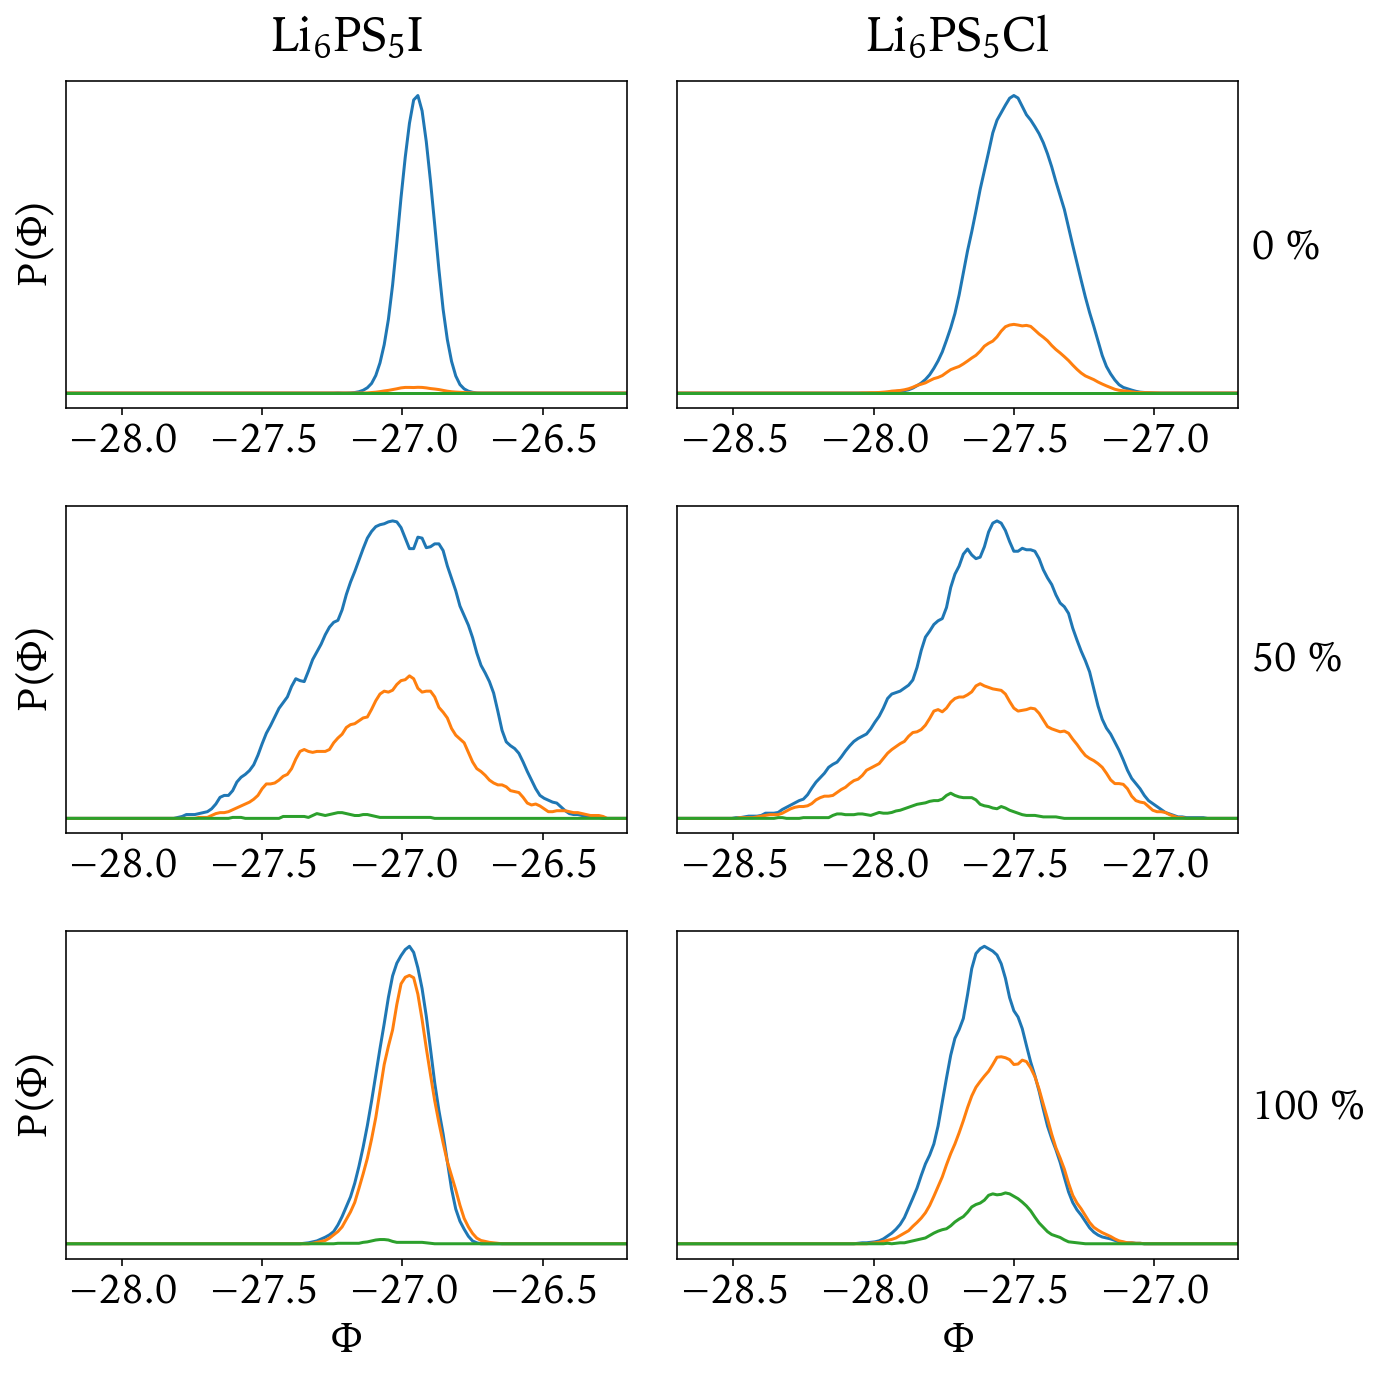

In [16]:
from matplotlib import rcParams

rcParams['font.serif'] = "Iowan Old Style"
rcParams['font.family'] = "serif"
rcParams['mathtext.fontset'] = 'custom'
rcParams['mathtext.rm'] = 'Iowan Old Style'
rcParams['mathtext.it'] = 'Iowan Old Style:italic'
rcParams['mathtext.bf'] = 'Iowan Old Style:bold'
rcParams['pdf.fonttype'] = 42
rcParams['ps.fonttype'] = 42
rcParams.update({'font.size': 20})

fig, ax = plt.subplots(3,2,figsize=(10,10))

for axx, disorder in zip(ax, ['0p', '50p', '100p']):
    for axes, system in zip(axx, ['Li6PS5I', 'Li6PS5Cl']):
        a = trajectory[system][disorder]
        at = np.array(a.atoms_trajectory)
        pot = potentials[system][disorder]
        
        site_potentials = { '1': [], '2': [], '4': [], '5': [] }
        for i, p in zip(at.flatten(), pot.flatten()):
            site_potentials[a.site_by_index(i).label].append(p)
            
        plot_dist(site_potentials['5'], axes)
        plot_dist(site_potentials['2'], axes)
        plot_dist(site_potentials['4'], axes)
#         plot_dist(site_potentials['1'], axes)
for i in range(3):
    ax[i][0].set_xlim([-28.2,-26.2])
    ax[i][0].set_xticks([-28.0, -27.5, -27.0, -26.5])
    ax[i][1].set_xlim([-28.7,-26.7])
    ax[i][1].set_xticks([-28.5, -28.0, -27.5, -27.0])
    for j in range(2):
        ax[i][j].set_yticks([])
        
xlabel = r'$\Phi$'
ylabel = r'$P(\Phi)$'
ax[0,0].set_title(r'Li$_6$PS$_5$I', pad=15)
ax[0,1].set_title(r'Li$_6$PS$_5$Cl', pad=15)
ax[2,0].set(xlabel=xlabel, ylabel=ylabel)
ax[1,0].set(ylabel=ylabel)
ax[0,0].set(ylabel=ylabel)
ax[2,1].set(xlabel=xlabel)

ax[0,1].text(-26.65,800,'0 %')
ax[1,1].text(-26.65,200,'50 %')
ax[2,1].text(-26.65,260,'100 %')

plt.tight_layout()
plt.savefig('../../figures/site_potentials.pdf')
plt.show()